In [111]:
module KfWorld

using Plots
using Distributions
using StatsBase
using LinearAlgebra
using Printf
using Logging
Logging.disable_logging(Logging.Info)

include("../scripts/mcl.jl")
import .MclWorld: RealRobot, RealCamera
import .MclWorld: EstimationAgent, IdealAgent, Agent, TrueLandmark, Landmark, Map, Camera, Robot, World
import .MclWorld: data, decision, state_transition, circle_shape, draw, append
import .MclWorld: observation_function
import .MclWorld: Estimator, Mcl, motion_update, observation_update

function sigma_ellipse(p, cov, n)
    eig_vals, eig_vec = eigen(cov)
    ang_rad = atan(eig_vec[:, 1][2], eig_vec[:,1][1])
                
    width = n*(eig_vals[1])^(1/2)
    height = n*(eig_vals[2])^(1/2)
    
    theta = LinRange(0, 2pi, 500)
    x = width * sin.(theta)
    y = height * cos.(theta)
    
    #R = [cos(angle_rad) -sin(angle_rad); sin(angle_rad) cos(angle_rad)]
    x_rotate = cos(ang_rad) .* x - sin(ang_rad) .* y
    y_rotate = sin(ang_rad) .* x + cos(ang_rad) .* y    
    
    return p[1] .+ x_rotate, p[2] .+ y_rotate
end

function matM(nu, omega, time, stds)
    return diagm([stds["nn"]^2*abs(nu)/time + stds["no"]^2*abs(omega)/time, stds["on"]^2*abs(nu)/time + stds["oo"]^2*abs(omega)/time])
end

function matA(nu, omega, time, theta)
    st, ct = sin(theta), cos(theta)
    stw, ctw = sin(theta + omega * time), cos(theta + omega * time)
    return [ (stw-st)/omega -nu/(omega^2)*(stw-st)+nu/omega*time*ctw;
             (-ctw+ct)/omega -nu/(omega^2)*(-ctw + ct) + nu/omega*time*stw;
             0 time]
end

function matF(nu, omega, time, theta)
    F = diagm([1.0, 1.0, 1.0])
    F[1, 3] = nu / omega * (cos(theta+omega*time) - cos(theta))
    F[2, 3] = nu / omega * (sin(theta+omega*time) - sin(theta))
    return F
end

function matH(pose, landmark_pos)
    mx, my = landmark_pos
    mux, muy, mut = pose
    q = (mux - mx)^2 + (muy - my)^2
    return [(mux-mx)/sqrt(q) (muy-my)/sqrt(q) 0; (my-muy)/q (mux-mx)/q -1]
end

function matQ(distance_dev, direction_dev)
    return diagm([distance_dev^2, direction_dev^2])
end

mutable struct KalmanFilter <: Estimator
    init_pose::Array{Float64}
    map::Map
    belief::MvNormal
    motion_noise_stds::Dict
    pose::Array{Float64}
    distance_dev_rate::Float64
    direction_dev::Float64

    function KalmanFilter(
        init_pose;
        map=Map(),
        belief = MvNormal([0, 0, 0], diagm([1e-10, 1e-10, 1e-10])),
        motion_noise_stds=Dict([("nn", 0.19), ("no", 0.001), ("on", 0.13), ("oo", 0.2)]),
        pose = mean(belief),
        distance_dev_rate=0.14,
        direction_dev=0.05
        )
        
        new(
            init_pose,
            map,
            belief,
            motion_noise_stds,
            pose,
            distance_dev_rate,
            direction_dev
        )
    end

end

function motion_update(self::Estimator, nu, omega, time)
        
    if abs(omega) < 1e-5
        omega = 1e-5
    end
    
    M = matM(nu, omega, time, self.motion_noise_stds)
    A = matA(nu, omega, time, mean(self.belief)[3])
    F = matF(nu, omega, time, mean(self.belief)[3])

    sigma = F * cov(self.belief) * F' + A * M * A'
    mu = state_transition(nu, omega, time, mean(self.belief))
    self.belief = MvNormal(mu, Matrix(Hermitian(sigma)))
    
    self.pose = mean(self.belief)
end

function observation_update(self::Estimator, observation)
    
    for (key, value) in observation
        z = value
        obs_id = key

        H = matH(mean(self.belief), self.map.landmarks[obs_id].pos)
        estimated_z=observation_function(mean(self.belief), self.map.landmarks[obs_id].pos)
        Q = matQ(estimated_z[1]*self.distance_dev_rate, self.direction_dev)
        K = cov(self.belief)*H'*inv(Q+H*cov(self.belief)*H')
        mu = mean(self.belief) + K * (z - estimated_z)
        sigma = (1.0*I(3)-K*H)*cov(self.belief)
        self.belief = MvNormal(mu, Matrix(Hermitian(sigma)))
        self.pose = mean(self.belief)        
    end

end

function draw(self::Estimator, plt)    
    
    mu = mean(self.belief)
    sigma = cov(self.belief)
    
    ex, ey = sigma_ellipse(mu[1:2], sigma[1:2, 1:2], 3)
    plot!(plt, ex, ey, c=:blue, label="")

    x, y, c = mean(self.belief)
    sigma3 = sqrt(cov(self.belief)[3, 3])*3
    xs = [x + cos(c-sigma3), x, x + cos(c+sigma3)]
    ys = [y + sin(c-sigma3), y, y + sin(c+sigma3)]   
    plot!(plt, xs, ys, c=:blue, alpha=0.5, label="")

end

end

Main.KfWorld

Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_kalman_filter/tmp.gif")
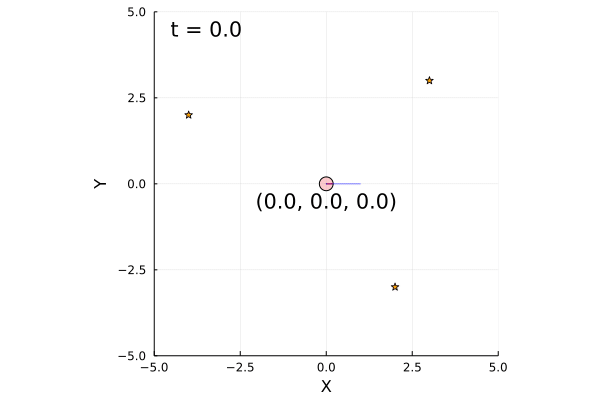

In [115]:
time_interval = 0.1    
world = KfWorld.World(30, 0.1)

### 地図を生成して３つランドマークを追加 ###
m = KfWorld.Map()
KfWorld.append(m, KfWorld.TrueLandmark([-4, 2]))
KfWorld.append(m, KfWorld.TrueLandmark([2, -3]))
KfWorld.append(m, KfWorld.TrueLandmark([3, 3]))
KfWorld.append(world, m)

initial_pose = [0, 0, 0]
kf = KfWorld.KalmanFilter(initial_pose, map=m)
circling = KfWorld.EstimationAgent(time_interval, 0.2, 10.0/180.0*pi, kf)
r = KfWorld.RealRobot(initial_pose, :red, 0.2, circling, sensor=KfWorld.RealCamera(m))

KfWorld.append(world, r)
KfWorld.draw(world)

Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_kalman_filter/tmp.gif")
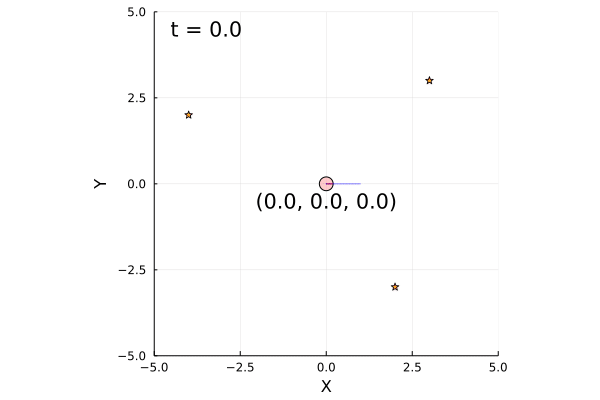

In [116]:
time_interval = 0.1    
world = KfWorld.World(30, 0.1)

### 地図を生成して３つランドマークを追加 ###
m = KfWorld.Map()
KfWorld.append(m, KfWorld.TrueLandmark([-4, 2]))
KfWorld.append(m, KfWorld.TrueLandmark([2, -3]))
KfWorld.append(m, KfWorld.TrueLandmark([3, 3]))
KfWorld.append(world, m)

initial_pose = [0, 0, 0]
kf = KfWorld.KalmanFilter(initial_pose, map=m)
circling = KfWorld.EstimationAgent(time_interval, 0.2, 10.0/180.0*pi, kf)

cam = KfWorld.RealCamera(m, distance_noise_rate=0.0, direction_noise=0.0,
    distance_bias_rate_stddev=0.0,
    direction_bias_stddev=0.0,
    oversight_prob=0.0,
    occlusion_prob=0.0)

r = KfWorld.RealRobot(initial_pose, :red, 0.2, circling, sensor=cam)
KfWorld.append(world, r)

KfWorld.draw(world)